In [18]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150
import numpy as np
import awkward as ak
import scipy.stats
import scipy.integrate
import seaborn as sns
import numba
from shapely.geometry import Polygon, LineString, MultiPoint

from numba.typed import List

from gnn_testbed.event_generation import (
    Detector,
    proposal_setup,
    generate_cascade,
    generate_realistic_tracks,
    make_line,
    trigger,
    get_proj_area_for_zen,
    
)

from gnn_testbed.event_generation.detector import sample_cylinder_surface
from gnn_testbed.plotting import plot_events, plot_event
from gnn_testbed.feature_generation import get_features
from gnn_testbed.event_generation.photon_propagation import BiolumiSource, generate_biolumi_photons, dejit_biolumi_sources
from gnn_testbed.event_generation.mc_record import MCRecord
from gnn_testbed.event_generation import proposal_setup, Constants

prop = proposal_setup()

In [2]:
rng = np.random.RandomState(31338)
oms_per_line = 50
dist_z = 20

modules = make_line(-75, -65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
modules += make_line(75, -65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
modules += make_line(0, 65, dist_z, oms_per_line, rng, 16*1e-6, 0, efficiency=0.3)
det = Detector(modules)

lc_links = {}
for i in range(60):
  
    links = list(range(max(i-1, (i//20)*20), min(i+2, (i//20+1)*20)))
    links.remove(i)
    lc_links[i] = links

height = 1500
radius = 300
    

In [53]:
def make_poly(zen, azi):
    x = np.sin(zen) * np.cos(azi)
    y = np.sin(zen) * np.sin(azi)
    z = np.cos(azi)
    
    u = np.asarray([-y, x, 0])
    v = np.asarray([0, -z, y])
    
    p1 = -1000 * u
    p2 = 1000*u
    p3 = -1000*u + 1000*v
    p4 = 1000*u + 1000*v
    
    points = MultiPoint([p1, p2, p3, p4])
    hull = points.convex_hull
    
    return hull
    
    

In [57]:
make_poly(np.pi/2, 0).length

3000.0

In [58]:
points = MultiPoint(det.module_coords)
points.convex_hull

isec = points.convex_hull.intersection(make_poly(np.pi/2, 0))

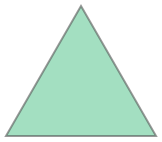

In [61]:
points.convex_hull

In [60]:
isec.area

0.0

In [49]:
for bound in mapoly.exterior:
    print(bound)
    break

AttributeError: 'LineString' object has no attribute 'exterior'

In [46]:
isec.lengthMultiPoint

75.0

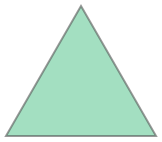

In [39]:
points.convex_hull

In [13]:
poly = Polygon([(-75, -65),(75, -65), (0, 65)])

for 


line = LineString([(-100, 0), (100, 0)])

isec = poly.intersection(line)

In [16]:
isec.length

75.0

In [57]:
tracks, track_records = generate_realistic_tracks(det, height, radius, 20000, seed=31337, propagator=prop, log_emin=1, log_emax=7, filter=False,
                                                 photocathode_area=16 * (7.62/2)**2 * np.pi * 1E-4)

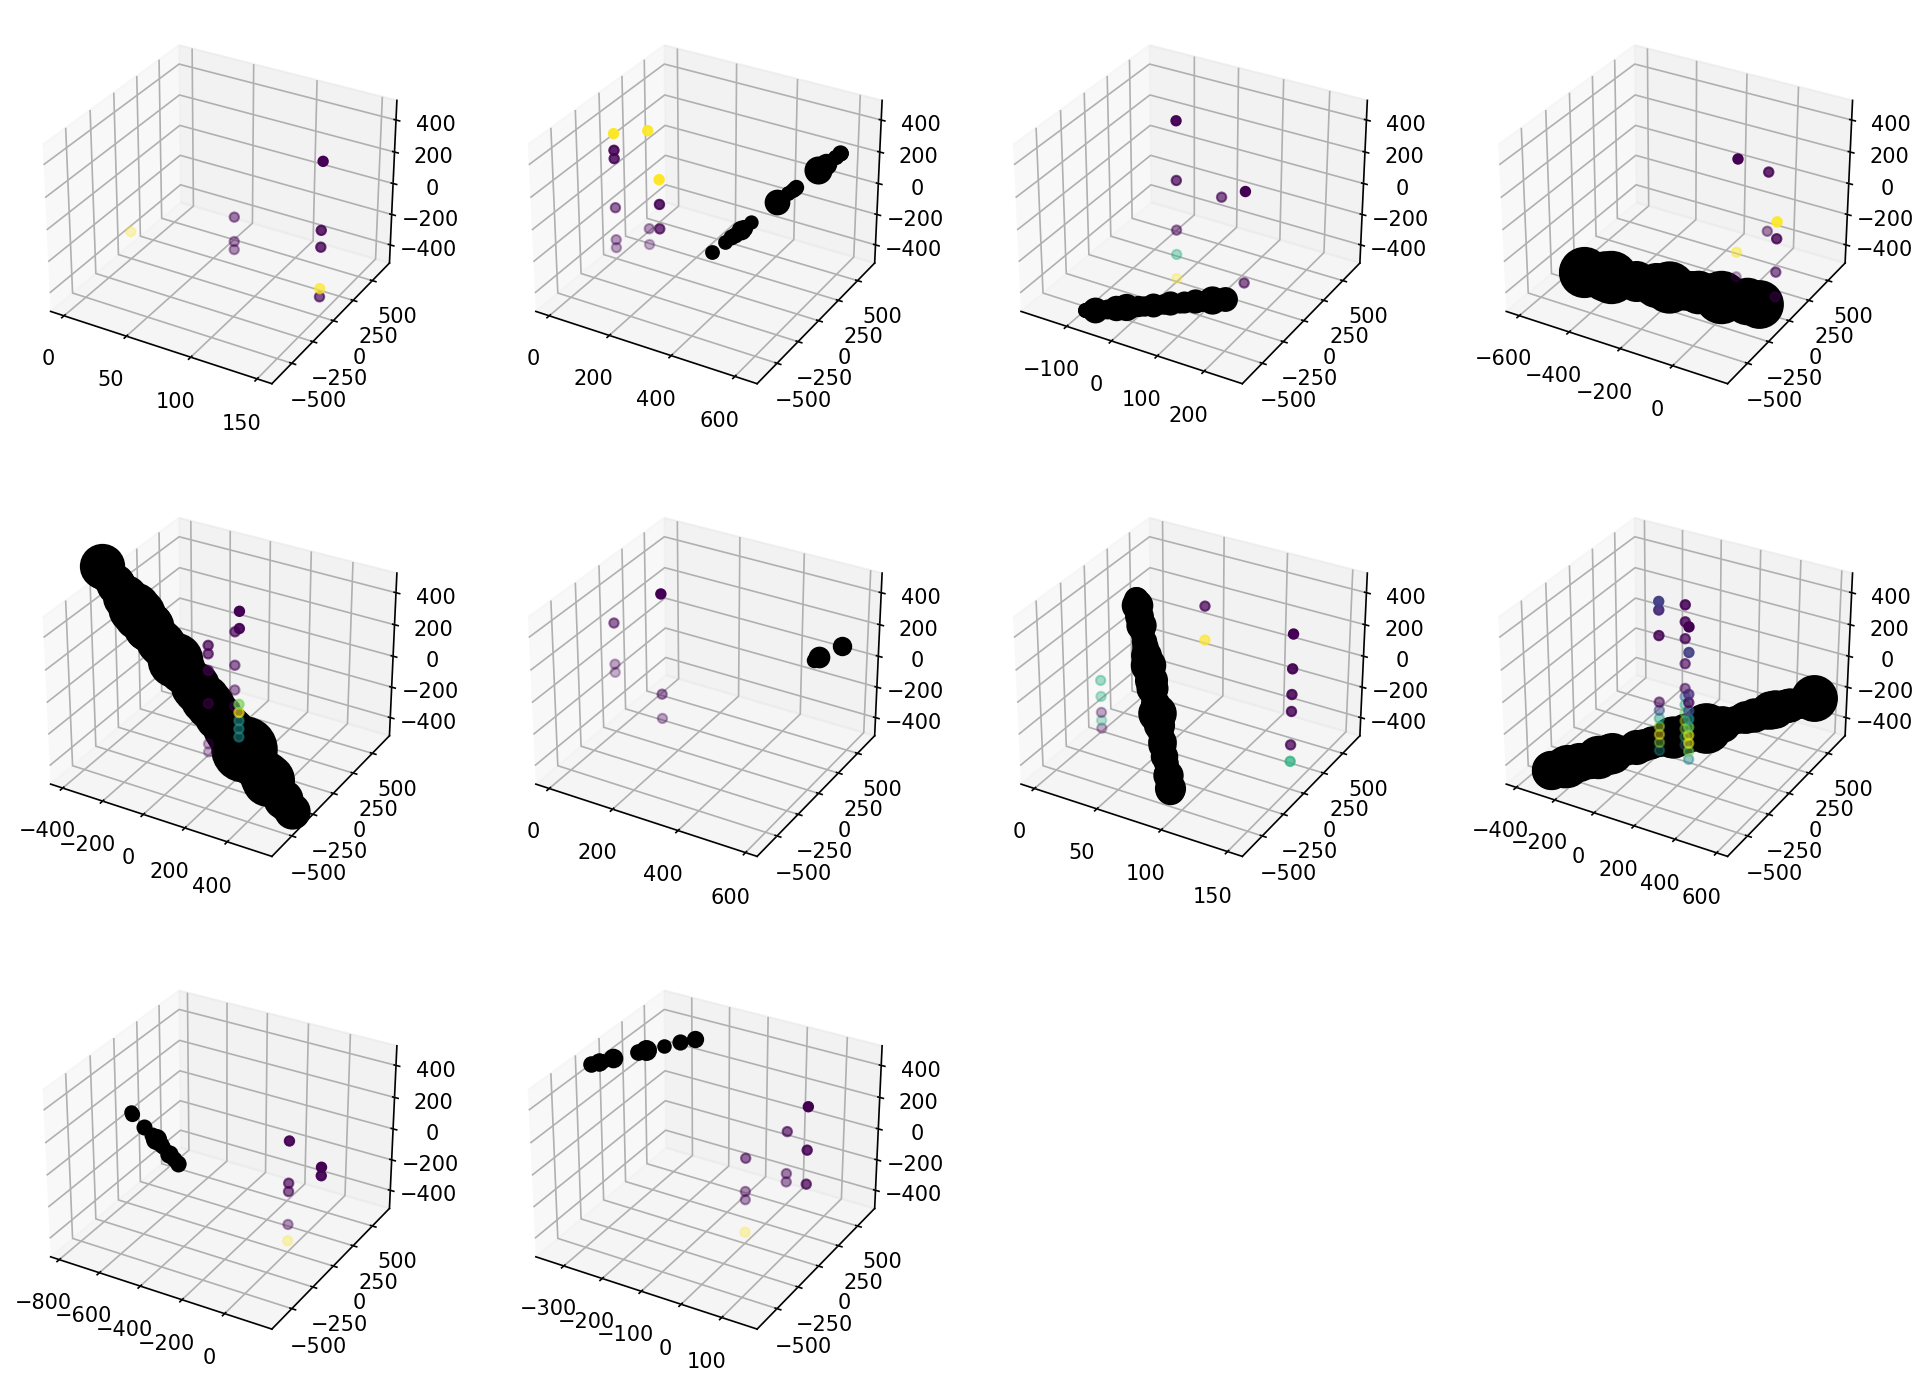

In [58]:
plot_events(det, tracks[10:20], records=track_records[10:20], );

In [59]:
proj_area_int = scipy.integrate.quad(lambda ct: get_proj_area_for_zen(1500, 300, ct), -1, 1)[0] / (2)
proj_area_det_int = scipy.integrate.quad(lambda ct: get_proj_area_for_zen(1000, 150, ct), -1, 1)[0] / (2)

In [63]:
triggers = []
for event in tracks:
    triggers.append(trigger(det, event))

In [61]:
track_records[0].mc_info[0]

{'position': array([-1501.41717336,   472.2776368 ,    68.7208456 ]),
 'energy': array([106.67861298]),
 'track_len': 423.5289287482405,
 'direction': array([ 0.95908486, -0.11928145, -0.25676483])}

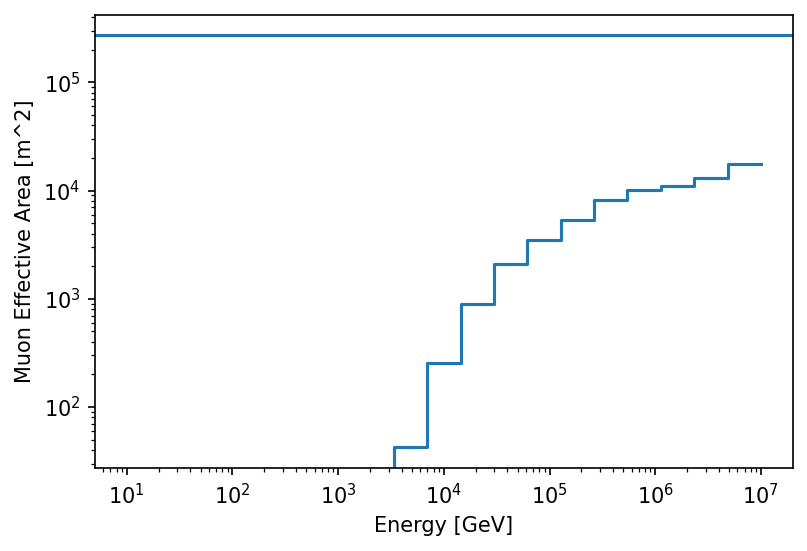

In [64]:
trigger_mask = np.asarray(triggers)

energies = np.asarray([tr.mc_info[0]["energy"][0] for tr in track_records])
areas = np.asarray([get_proj_area_for_zen(height, radius, np.cos(tr.mc_info[0]["direction"][2])) for tr in track_records]) 


ebins = np.logspace(1, 7, 20)

thist, _ = np.histogram(energies[trigger_mask], ebins, weights=np.ones(trigger_mask.sum()) * proj_area_int / 20000)
#thist, _ = np.histogram(energies, ebins, weights=areas / 10000)
#hist, _ = np.histogram(energies, ebins)

#ratio = thist/hist

plt.step(ebins, np.append(thist, thist[-1]), where="post")
plt.loglog()
plt.xlabel("Energy [GeV]")
plt.ylabel("Muon Effective Area [m^2]")
plt.axhline(proj_area_det_int, label="Geometric Area")

In [25]:
scipy.integrate.quad(lambda ct: get_proj_area_for_zen(1500, 300, ct), -1, 1)[0] / (2)

848230.0164692438

In [20]:
areas.sum() / 2E4

653743.932784705

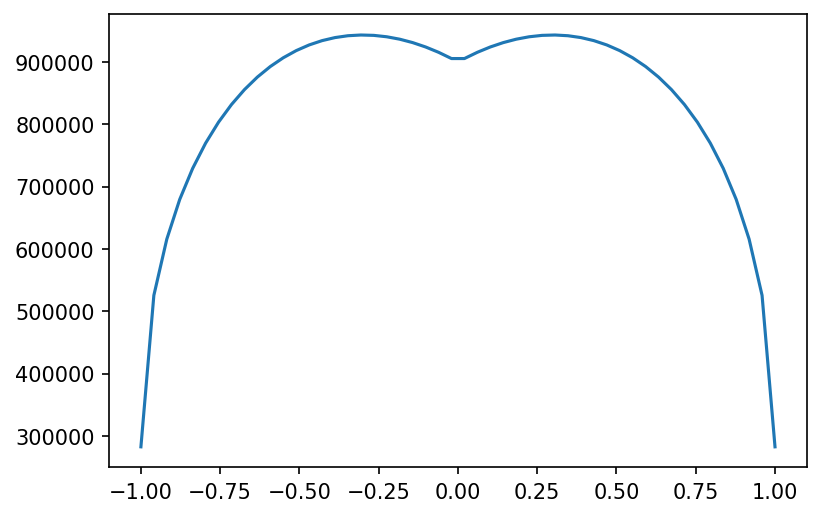

In [17]:
cz = np.linspace(-1, 1)
plt.plot(cz, get_proj_area_for_zen(1500, 300, cz))

In [42]:
np.average(get_proj_area_for_zen(1500, 300, np.random.uniform(-1, 1, size=100000)))

848210.9467750995

<AxesSubplot:ylabel='Count'>

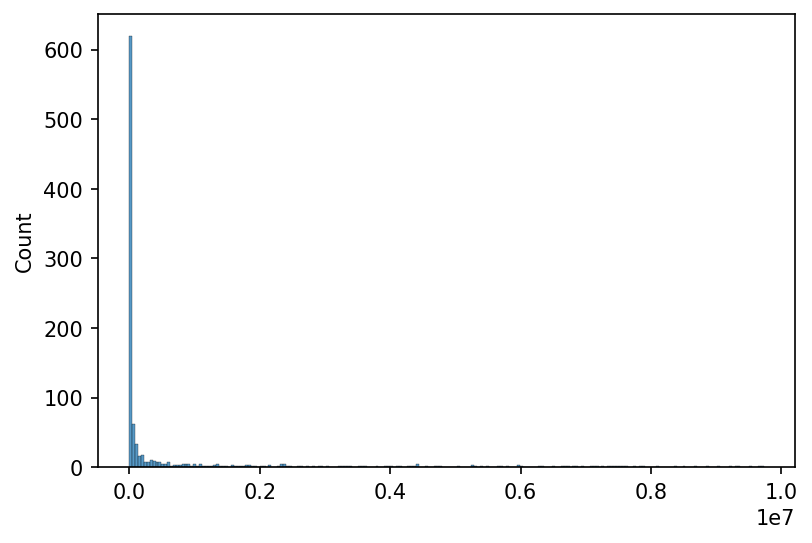

In [36]:
sns.histplot(10**np.random.uniform(1, 7, 1000))

In [6]:
get_proj_area_for_zen(1500, 300, np.cos(np.pi/2))

900000.0

In [7]:
600 * 1500

900000